In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import SimpleITK as sitk
import advanced_radiomics.extract as ext

import cv2
import os
import glob

from scipy.stats import skew, kurtosis

# Functions

In [2]:
def getImages(case_name):
    """
    Função que recebe um caso e seleciona a imagem cropped.
    """
    path = f"../data/mamografia/data/CBIS-DDSM/{case_name}/**/*.dcm"
    r = glob.glob(path, recursive=True)
    
    size_min = np.inf
    crop_file = None
    
    for file in r:
        size = os.path.getsize(file)
        if size < size_min:
            size_min = size
            crop_file = file
        
    return ext.openFile(crop_file)


def getFirstOrderFeatures(crop_img):
    """
    Função que calcula features de primeira ordem dada uma imagem.
    """
    
    # Os pixels do arquivo .dcm vão de 0 até 65535 (int16), para evitar
    # trabalhar com números muito grandes, dividir por 65535.
    crop_np = (sitk.GetArrayFromImage(crop_img)/65535).flatten()
    
    ### Calcula todas as features
    Energy = np.sum(crop_np**2)
    Min = np.min(crop_np)
    Max = np.max(crop_np)
    Mean = np.mean(crop_np)
    Std = np.std(crop_np)
    Skew = skew(crop_np)
    Kurtosis = kurtosis(crop_np)
    
    ### Cria DataFrame com essas features
    columns = ["Energy", "Min", "Max", "Mean", "Std", "Skewness", "Kurtosis"]
    values = [[Energy, Min, Max, Mean, Std, Skew, Kurtosis]]
    feat_df = pd.DataFrame(values, columns=columns)
    return feat_df


def pipelineFO(case_name):
    """
    
    """
    
    crop_img = getImages(case_name)
    
    return getFirstOrderFeatures(crop_img)


def createBins(image, n_bins=8):
    image_np = sitk.GetArrayFromImage(image)/65535
    return np.sum(list(map(lambda v: image_np > v, np.linspace(0,image_np.max(),n_bins))), axis=(0,1))


def calcGLCMFeatures(image_np):
    glcm_matrix = greycomatrix(image_np.astype(np.uint8), [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=32)
    #glcm_matrix_final = glcm_matrix.mean(axis=(2,3)).reshape((glcm_matrix.shape[0], glcm_matrix.shape[1], 1, 1))
    
    cols = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    angles = [0,45,90, 135]
    columns = []
    values = []
    for col in cols:
        values.append(greycoprops(glcm_matrix, col).flatten())
        columns += list(map(lambda a: f"{col}_{a}", angles))
    
    return pd.DataFrame(np.concatenate(values).reshape(1,-1), columns=columns)
    
    
def pipelineGLCM(case_name, bins=32):
    crop_img = getImages(case_name)
    
    crop_bin = createBins(crop_img, bins)
    
    return calcGLCMFeatures(crop_bin)

# Main

In [3]:
### Abrindo dados de treino e teste
train_mass = pd.read_csv("../data/mamografia/data/mass_case_description_train_set.csv")
test_mass = pd.read_csv("../data/mamografia/data/mass_case_description_test_set.csv")

### Abrindo metadata
metadata = pd.read_csv(os.path.join("../data/mamografia/data/metadata.csv"))

### Gerando o informação para juntar com informação do metadata
train_mass["Data Description URI"] = train_mass["cropped image file path"].apply(lambda r: r.split("/")[0])
test_mass["Data Description URI"] = test_mass["cropped image file path"].apply(lambda r: r.split("/")[0])
train_mass = train_mass[train_mass["pathology"] != "BENIGN_WITHOUT_CALLBACK"].reset_index(drop=True)
test_mass = test_mass[test_mass["pathology"] != "BENIGN_WITHOUT_CALLBACK"].reset_index(drop=True)

### Juntando as duas bases
# Aqui pode gerar linhas quase que duplicadas, pois alguns 'ROIs' e 'Cropped images'
# foram salvas em subpastas distintas. No entanto, o código para acessar o cropped
# é invariante a isso, portanto, é possível remover essas linhas sem problema.
train_df = train_mass.merge(metadata).drop_duplicates("Data Description URI")
test_df = test_mass.merge(metadata).drop_duplicates("Data Description URI")

### Removendo os casos 'Bening withou callback'
train_df = train_df[train_df["pathology"] != "BENIGN_WITHOUT_CALLBACK"]
test_df = test_df[test_df["pathology"] != "BENIGN_WITHOUT_CALLBACK"]

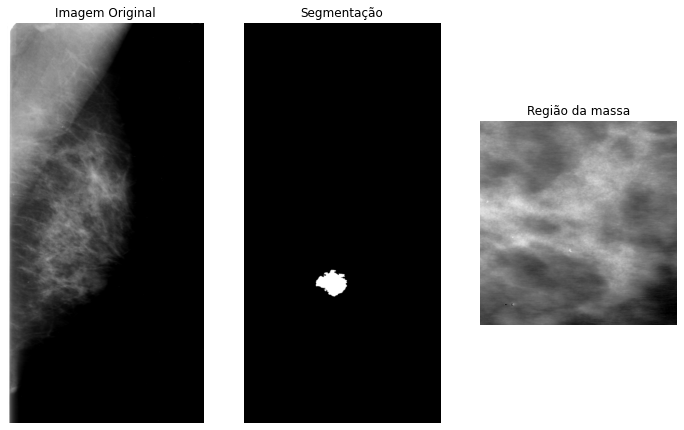

In [4]:
### Abrindo um caso de exemplo
image_original_path = "../data/mamografia/data/CBIS-DDSM/Mass-Test_P_00145_LEFT_MLO/10-04-2016-DDSM-NA-06894/1.000000-full mammogram images-73003/1-1.dcm"
image_crop_path = "../data/mamografia/data/CBIS-DDSM/Mass-Test_P_00145_LEFT_MLO_1/10-04-2016-DDSM-NA-02159/1.000000-cropped images-45939/1-1.dcm"
image_roi_path = "../data/mamografia/data/CBIS-DDSM/Mass-Test_P_00145_LEFT_MLO_1/10-04-2016-DDSM-NA-52166/1.000000-ROI mask images-28215/1-1.dcm"

image_original = ext.openFile(image_original_path)
image_roi = ext.openFile(image_roi_path)
image_crop = ext.openFile(image_crop_path)

### Visualização dos 3 tipos de imagens
fig, ax =  plt.subplots(1,3, figsize=(12,8))
ax[0].imshow(sitk.GetArrayFromImage(image_original)[0], cmap='gray')
ax[0].axis('off')
ax[0].set_title("Imagem Original")
ax[1].imshow(sitk.GetArrayFromImage(image_roi)[0], cmap='gray')
ax[1].axis('off')
ax[1].set_title("Segmentação")
ax[2].imshow(sitk.GetArrayFromImage(image_crop)[0], cmap='gray')
ax[2].axis('off')
ax[2].set_title("Região da massa")
plt.show()

### Análise de features

Temos duas classes, massas malignas e benignas, no nosso dataset. Será que existem características simples que já ajudam a diferenciar essas duas classes?

Para isso, veremos 3 tipos de features diferentes:
<br>1 - Features de Primeira Ordem
<br>2 - Features de Geometria
<br>3 - Features de Segunda Ordem

### FO (Features de Primeira Ordem)

Features de primeira ordem são features que analisam o histograma da imagem, não analisando a relação entre os pixels vizinhos.

In [5]:
### Gerando as features de treino e teste
result_train = train_mass["Data Description URI"].apply(pipelineFO)
result_test = test_mass["Data Description URI"].apply(pipelineFO)

### Convertendo para Pandas
fo_train_df = pd.concat(result_train.values).reset_index(drop=True)
fo_test_df = pd.concat(result_test.values).reset_index(drop=True)

### Juntando com os dados de patologia e criando a classe (maligno 1, benigno 0)
fo_train_df = pd.concat([train_mass[["pathology"]], fo_train_df], axis=1)
fo_train_df["classe"] = (fo_train_df["pathology"] == "MALIGNANT").astype(int)
fo_test_df = pd.concat([test_mass[["pathology"]], fo_test_df], axis=1)
fo_test_df["classe"] = (fo_test_df["pathology"] == "MALIGNANT").astype(int)

In [6]:
### Criando os X e y
X_train = fo_train_df.drop(["pathology", "classe", "Max"], axis=1).values
y_train = fo_train_df["classe"].values
X_test = fo_test_df.drop(["pathology", "classe", "Max"], axis=1).values
y_test = fo_test_df["classe"].values

### Calculando os valores minimos e maximos para normalização
X_max = X_train.max(axis=0)
X_min = X_train.min(axis=0)

### Normalizando treino e teste
X_train_n = (X_train - X_min)/(X_max - X_min)
X_test_n = (X_test - X_min)/(X_max - X_min)

In [7]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [8]:
### Treinando um Gradient Boosting
model = GradientBoostingClassifier().fit(X_train_n, y_train)
y_predict = model.predict_proba(X_test_n)[:,1]

### Printando métrica
print(f"AUC: {round(roc_auc_score(y_test, y_predict),3)}")

AUC: 0.556


### Features de Geometria (Shape)

In [9]:
### Pegando o Dummies da coluna do formato (treino)
train_dummies = pd.get_dummies(train_mass["mass shape"])
print(f"Número de geometrias no treino: {train_dummies.shape}")

### Pegando o Dummies da coluna do formato (teste)
test_dummies = pd.get_dummies(test_mass["mass shape"])
print(f"Número de geometrias no teste: {test_dummies.shape}")

### Criando a lista com todas os tipos de formatos
columns = set(test_dummies.columns).union(set(train_dummies.columns))
columns = list(columns)

Número de geometrias no treino: (1214, 15)
Número de geometrias no teste: (341, 12)


In [10]:
### Número de formatos distintos
print(f"Número de formatos distintos: {len(columns)}")

### Preenchendo os formatos 'faltantes'
for col in columns:
    ### Treino
    if col not in train_dummies.columns:
        train_dummies[col] = 0
    
    ### Teste
    if col not in test_dummies.columns:
        test_dummies[col] = 0

Número de formatos distintos: 18


In [11]:
### Criando os X e y
X_train = train_dummies[columns].values
y_train = (train_mass["pathology"] == "MALIGNANT").astype(int).values
X_test = test_dummies[columns].values
y_test = (test_mass["pathology"] == "MALIGNANT").astype(int).values

In [12]:
### Treinando um Gradient Boosting
model = GradientBoostingClassifier().fit(X_train, y_train)
y_predict = model.predict_proba(X_test)[:,1]

### Printando métrica
print(f"AUC: {round(roc_auc_score(y_test, y_predict),3)}")

AUC: 0.769


In [13]:
importance_df = pd.DataFrame(model.feature_importances_.reshape(1,-1), columns=columns)
importance_df = importance_df.sort_values(0, axis=1)

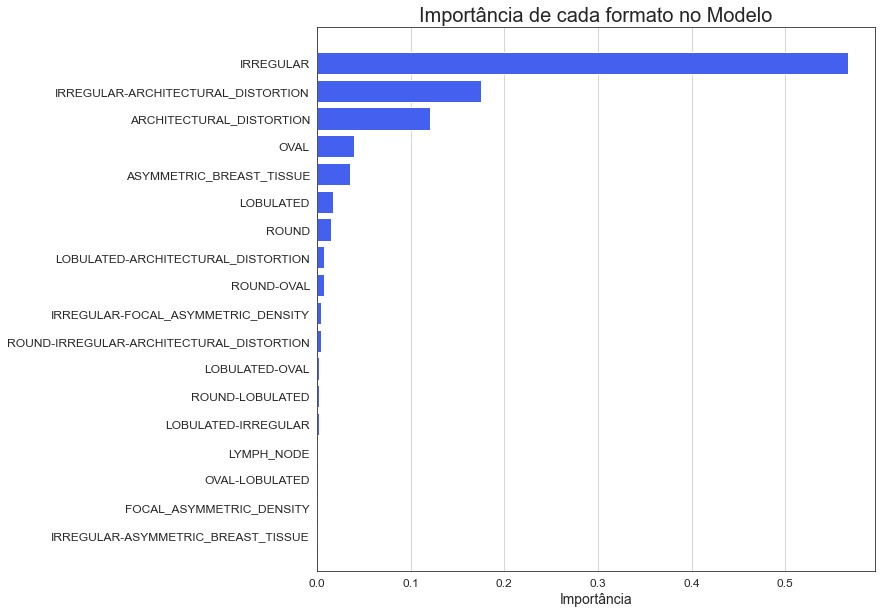

In [14]:
with sns.axes_style('white'):
    plt.figure(figsize=(10, 10))
    plt.barh(importance_df.columns, importance_df.values.flatten(), color='#4361ee')
    plt.title("Importância de cada formato no Modelo", fontsize=20)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Importância", fontsize=14)
    plt.grid(axis='x')
    plt.show()

In [15]:
i_df = train_mass[train_mass["mass shape"] == "IRREGULAR"]["pathology"].value_counts(normalize=True).to_frame(name="Irregular")
ni_df = train_mass[train_mass["mass shape"] != "IRREGULAR"]["pathology"].value_counts(normalize=True).to_frame(name="Not Irregular")
concat_df = pd.concat([i_df, ni_df], axis=1)
concat_df

,Irregular,Not Irregular
MALIGNANT,0.839181,0.401376
BENIGN,0.160819,0.598624


### Features de Segunda ordem

In [16]:
from skimage.feature import greycomatrix, greycoprops

In [17]:
image_example = getImages("Mass-Training_P_00133_LEFT_CC_1")

image_2 = createBins(image_example, 2)
image_4 = createBins(image_example, 4)
image_8 = createBins(image_example, 8)
image_16 = createBins(image_example, 16)
image_32 = createBins(image_example, 32)

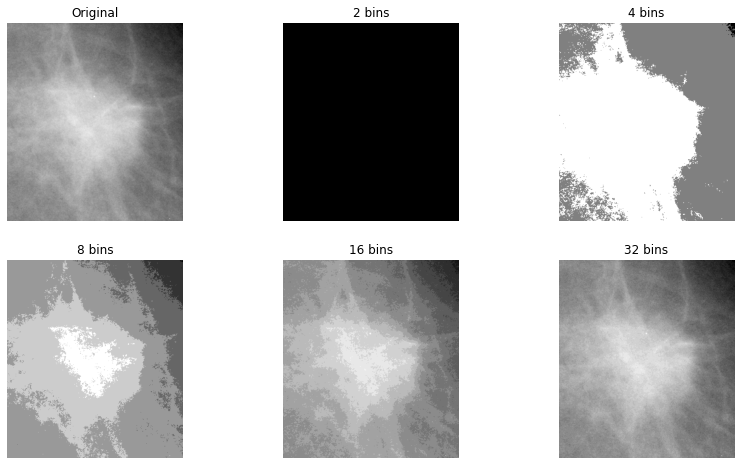

In [18]:
fig, ax =  plt.subplots(2,3, figsize=(14,8))
image_np = sitk.GetArrayFromImage(image_example)
ax[0,0].imshow(image_np[0], cmap='gray')
ax[0,0].axis('off')
ax[0,0].set_title("Original")
ax[0,1].imshow(image_2, cmap='gray')
ax[0,1].axis('off')
ax[0,1].set_title("2 bins")
ax[0,2].imshow(image_4, cmap='gray')
ax[0,2].axis('off')
ax[0,2].set_title("4 bins")
ax[1,0].imshow(image_8, cmap='gray')
ax[1,0].axis('off')
ax[1,0].set_title("8 bins")
ax[1,1].imshow(image_16, cmap='gray')
ax[1,1].axis('off')
ax[1,1].set_title("16 bins")
ax[1,2].imshow(image_32, cmap='gray')
ax[1,2].axis('off')
ax[1,2].set_title("32 bins")
plt.show()

In [19]:
### Gerando as features de treino e teste
result_train = train_mass["Data Description URI"].apply(pipelineGLCM)
result_test = test_mass["Data Description URI"].apply(pipelineGLCM)

### Convertendo para Pandas
glcm_train_df = pd.concat(result_train.values).reset_index(drop=True)
glcm_test_df = pd.concat(result_test.values).reset_index(drop=True)

### Juntando com os dados de patologia e criando a classe (maligno 1, benigno 0)
glcm_train_df = pd.concat([train_mass[["pathology"]], glcm_train_df], axis=1)
glcm_train_df["classe"] = (glcm_train_df["pathology"] == "MALIGNANT").astype(int)
glcm_test_df = pd.concat([test_mass[["pathology"]], glcm_test_df], axis=1)
glcm_test_df["classe"] = (glcm_test_df["pathology"] == "MALIGNANT").astype(int)

In [20]:
### Criando os X e y
X_train = glcm_train_df.drop(["pathology", "classe"], axis=1).values
y_train = glcm_train_df["classe"].values
X_test = glcm_test_df.drop(["pathology", "classe"], axis=1).values
y_test = glcm_test_df["classe"].values

In [21]:
### Treinando um Gradient Boosting
model = GradientBoostingClassifier().fit(X_train, y_train)
y_predict = model.predict_proba(X_test)[:,1]

### Printando métrica
print(f"AUC: {round(roc_auc_score(y_test, y_predict),3)}")

AUC: 0.59


### Juntando tudo

In [22]:
### Juntando todas as informações
train_full = pd.concat([fo_train_df, train_dummies, glcm_train_df], axis=1)
test_full = pd.concat([fo_test_df, test_dummies, glcm_test_df], axis=1)

In [23]:
### Criando treino e teste
X_train = train_full.drop(["pathology", "Max", "classe"], axis=1).values
X_test = test_full.drop(["pathology", "Max", "classe"], axis=1).values

In [24]:
### Treinando um Gradient Boosting
model = GradientBoostingClassifier().fit(X_train, y_train)
y_predict = model.predict_proba(X_test)[:,1]

### Printando métrica
print(f"AUC: {round(roc_auc_score(y_test, y_predict),3)}")

AUC: 0.784
